In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

In [2]:
df  = pd.read_csv("car_details_from_car_dekho.csv.xls")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [3]:
enc = LabelEncoder()

#split name into company and model
df['company'] = df['name'].apply(lambda x: x.split(' ')[0])
df['model'] = df['name'].apply(lambda x: x.split(' ')[1])
df2 = df.drop(['name'], axis=1)

enc.fit(df['company'])
df['company'] = enc.transform(df['company'])
enc.fit(df['model'])
df['model'] = enc.transform(df['model'])
enc.fit(df['seller_type'])
df['seller_type'] = enc.transform(df['seller_type'])
enc.fit(df['owner'])
df['owner'] = enc.transform(df['owner'])
enc.fit(df['fuel'])
df['fuel'] = enc.transform(df['fuel'])
enc.fit(df['transmission'])
df['transmission'] = enc.transform(df['transmission'])

cdf = df[['year', 'selling_price', 'km_driven','company','seller_type','model']]
cdf.head(9)

,year,selling_price,km_driven,company,seller_type,model
0,2007,60000,70000,18,1,6
1,2007,135000,50000,18,1,164
2,2012,600000,100000,10,1,161
3,2017,250000,46000,5,1,125
4,2014,450000,141000,9,1,17
5,2007,140000,125000,18,1,14
6,2016,550000,25000,10,1,175
7,2014,240000,60000,25,1,83
8,2015,850000,25000,10,1,44


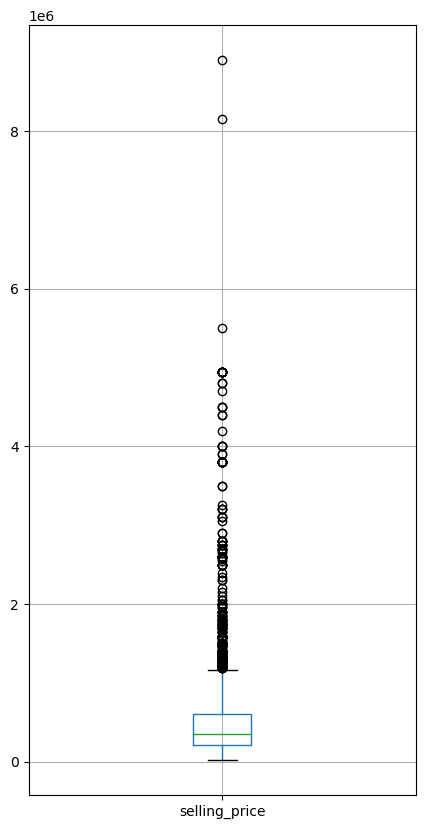

In [4]:
cdf2 = cdf[['selling_price']]
plt.figure(figsize=(5,10))
cdf2.boxplot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

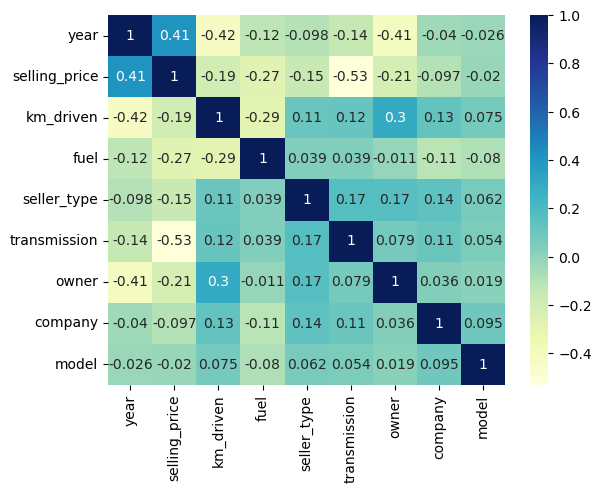

In [5]:
sns.heatmap(df.corr(),annot = True, cmap="YlGnBu")
plt.show

In [6]:
from sklearn import linear_model
from sklearn.metrics import r2_score

X = np.asanyarray(cdf[['year','km_driven', 'company', 'seller_type','model']])
Y = np.asanyarray(cdf[['selling_price']])

r2 = -1

while r2 < 0.2:
    random_st = np.random.randint(0, 100)
    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.65, random_state=random_st)
    regr = linear_model.LinearRegression()

    regr.fit (train_x, train_y)

    test_y_ = regr.predict(test_x)
    r2 = r2_score(test_y,test_y_)

print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2 )

Coefficients:  [[ 5.17700646e+04 -1.33910885e-02 -4.33747809e+03 -9.88369067e+04
  -2.56484532e+02]]
Intercept:  [-1.03541042e+08]
Mean absolute error: 267620.81
Residual sum of squares (MSE): 270157262125.85
R2-score: 0.20
